# wRMSD calculation

This notebook analyzes the results of molecular dynamics simulations of antibody molecules.
It calculates the root-mean-square deviation (RMSD) between the candidate antibody and the reference antibody,
and uses this to calculate the weighted RMSD (wRMSD) based on the accessibility and movability of each residue.

The notebook requires the MDAnalysis library to be installed.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import MDAnalysis as mda

In [2]:
# Define paths to the reference and candidates antibody simulation data
PATH_REFERENCE = 'md_simulations/remicade_humanization/remicade/'
PATH_CANDIDATE_Aa = 'md_simulations/remicade_humanization/candidate_Aa/'
PATH_CANDIDATE_Bb = 'md_simulations/remicade_humanization/candidate_Bb/'
PATH_CANDIDATE_Cb = 'md_simulations/remicade_humanization/candidate_Cb/'

# Define the CDR residues for the antibodies
CDRS = {
    'H1': (26, 33),    # 26-32
    'H2': (52, 60),    # 52-59
    'H3': (101, 110),  # 101-109
    'L1': (144, 155),  # 24-34
    'L2': (170, 177),  # 50-56
    'L3': (209, 218),  # 89-97
}

N = sum([val[1] - val[0] for val in CDRS.values()])

In [3]:
def load_antibody(dir_path):
    return mda.Universe(os.path.join(dir_path, 'structures/newbox.gro'),
                        os.path.join(dir_path, 'prod_0_80/prod_0_80_noPBC_center.xtc'))


# Load the reference and candidates antibody simulation data
reference = load_antibody(PATH_REFERENCE)
candidate_Aa = load_antibody(PATH_CANDIDATE_Aa)
candidate_Bb = load_antibody(PATH_CANDIDATE_Bb)
candidate_Cb = load_antibody(PATH_CANDIDATE_Cb)

traj_len = len(reference.trajectory)
simulation_time = 80.0 # 80 ns

reference, candidate_Aa, candidate_Bb, candidate_Cb

(<Universe with 3445 atoms>,
 <Universe with 3476 atoms>,
 <Universe with 3478 atoms>,
 <Universe with 3465 atoms>)

$$RMSD_i = \sqrt{\frac{\sum_j \left(d_{ij} - d_{ij}^0 \right)^2}{N - 1}}$$

$$wRMSD = \sum_i \frac{w_{i-accessibility} w_{i-movability} RMSD_i}{N}$$

$$w_{i-accessibility} = \frac{SASA_i}{SASA_{i.avg}}$$

$$w_{i-movability} = 1 / \left(\frac{RMSF_i^0}{RMSF_{i.avg}^0} \right)$$

In [4]:
def read_xvg_file(filename):
    data = []
    with open(filename, 'r') as f:
        for line in f:
            if line.startswith(('#', '@')):
                continue
            
            data.append(line)

    return np.loadtxt(data)


# Function to calculate the distance matrix from a set of coordinates
def coordinates2distance_matrix(coordinates):
    return np.sqrt(np.sum((coordinates[:, np.newaxis, :] - coordinates[np.newaxis, :, :]) ** 2, axis=-1))


def compute_wrmsd(candidate, reference, sasa, rmsf, 
                  cand_start=0, cand_end=traj_len, ref_start=0, ref_end=traj_len):
    reference_cdr = sum([reference.residues[val[0] - 1:val[1] - 1].atoms for val in CDRS.values()])
    reference_cdr_ca = reference_cdr.select_atoms('name CA')

    candidate_cdr = sum([candidate.residues[val[0] - 1:val[1] - 1].atoms for val in CDRS.values()])
    candidate_cdr_ca = candidate_cdr.select_atoms('name CA')
    
    rmsd = []
    assert ref_end - ref_start == cand_end - cand_start
    # Calculate the RMSD for each frame of the trajectories
    for ts_ref, ts_cand in tqdm(zip(reference.trajectory[ref_start:ref_end], 
                                    candidate.trajectory[cand_start:cand_end]), total=ref_end - ref_start):
        distance_matrix_ref = coordinates2distance_matrix(ts_ref[reference_cdr_ca.ix])
        distance_matrix_cand = coordinates2distance_matrix(ts_cand[candidate_cdr_ca.ix])
        rmsd.append(np.sqrt(np.sum((distance_matrix_cand - distance_matrix_ref) ** 2, axis=1) / (N - 1)))
    
    rmsd = np.array(rmsd)
    sasa_cropped = sasa[ref_start:ref_end, :]
    accessibility_weights = sasa_cropped / sasa_cropped.sum(axis=1).reshape(-1, 1)
    
    rmsf_cdr = np.hstack([rmsf[val[0] - 1:val[1] - 1] for val in CDRS.values()])
    movability_weights = rmsf_cdr.mean() / rmsf_cdr
    
    return np.sum(rmsd * accessibility_weights * movability_weights, axis=1)


# Function to calculate a sliding average for wRMSD visualization
def smooth_array(arr, window_size: int=10_000):
    smoothing_kernel = np.ones(window_size) / window_size
    return np.convolve(np.pad(arr, (window_size // 2, (window_size - 1) // 2), 'reflect'), 
                       smoothing_kernel, mode='valid')


def plot_wrmsd(wrmsd, window_size: int=10_000):
    plt.plot(wrmsd)
    plt.plot(smooth_array(wrmsd, window_size))
    plt.show()

In [5]:
sasa_reference = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/sasa_0_80.xvg'))[:, 2:]

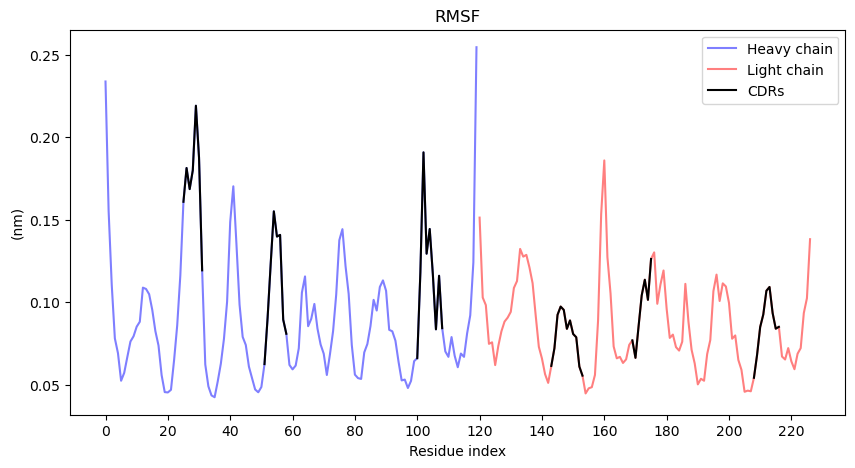

In [9]:
rmsf = read_xvg_file(os.path.join(PATH_REFERENCE, 'analysis/rmsf_0_80.xvg'))[:, 1]

plt.figure(figsize=(10, 5))
plt.plot(np.arange(120), rmsf[:120], 'b', alpha=0.5, label='Heavy chain')
plt.plot(np.arange(120, 227), rmsf[120:], 'r', alpha=0.5, label='Light chain')
for val in CDRS.values():
    if val[0] == 26:
        plt.plot(np.arange(val[0] - 1, val[1] - 1), rmsf[val[0] - 1:val[1] - 1], 'k', label='CDRs')
    else:
        plt.plot(np.arange(val[0] - 1, val[1] - 1), rmsf[val[0] - 1:val[1] - 1], 'k')
plt.title('RMSF')
plt.xlabel('Residue index')
plt.ylabel('(nm)')
plt.xticks(np.arange(0, 227, 20))
plt.legend()
# plt.savefig('presentation/rmsf_80ns.png')
plt.show()

In [10]:
wrmsd_Aa = compute_wrmsd(candidate_Aa, reference, sasa_reference, rmsf)
wrmsd_Bb = compute_wrmsd(candidate_Bb, reference, sasa_reference, rmsf)
wrmsd_Cb = compute_wrmsd(candidate_Cb, reference, sasa_reference, rmsf)

  0%|          | 0/400001 [00:00<?, ?it/s]

  0%|          | 0/400001 [00:00<?, ?it/s]

  0%|          | 0/400001 [00:00<?, ?it/s]

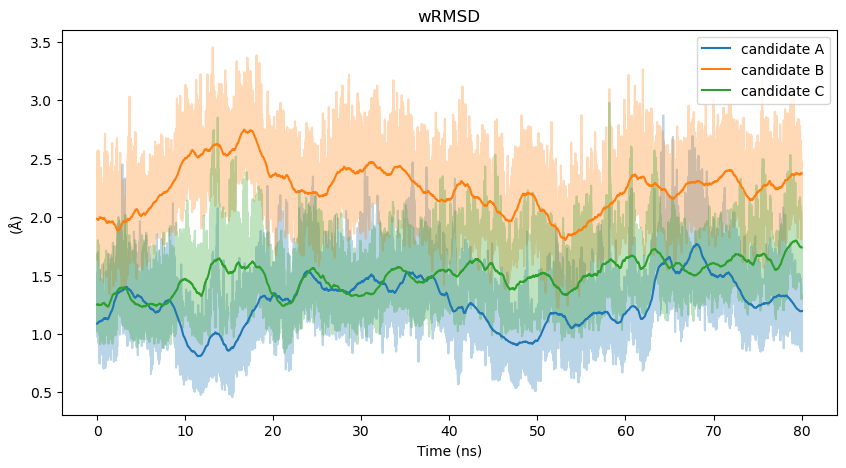

In [11]:
plt.figure(figsize=(10, 5))
plt.title('wRMSD')
plt.plot(np.linspace(0.0, simulation_time, traj_len), wrmsd_Aa, alpha=0.3)
plt.plot(np.linspace(0.0, simulation_time, traj_len), wrmsd_Bb, alpha=0.3)
plt.plot(np.linspace(0.0, simulation_time, traj_len), wrmsd_Cb, alpha=0.3)
plt.plot(np.linspace(0.0, simulation_time, traj_len), smooth_array(wrmsd_Aa), 'C0', label='candidate A')
plt.plot(np.linspace(0.0, simulation_time, traj_len), smooth_array(wrmsd_Bb), 'C1', label='candidate B')
plt.plot(np.linspace(0.0, simulation_time, traj_len), smooth_array(wrmsd_Cb), 'C2', label='candidate C')
plt.legend()
plt.ylabel('(Å)')
plt.xlabel('Time (ns)')
# plt.ylim(-0.1, 2.4)
# plt.savefig('presentation/wRMSD_plot.png')
plt.show()

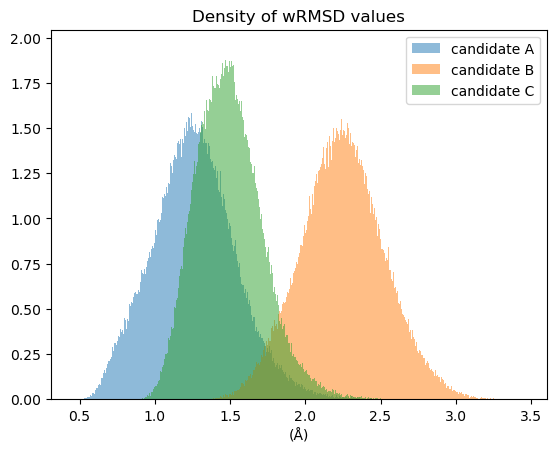

In [12]:
plt.title('Density of wRMSD values')
plt.hist(wrmsd_Aa, bins=1000, density=True, alpha=0.5, label='candidate A')
plt.hist(wrmsd_Bb, bins=1000, density=True, alpha=0.5, label='candidate B')
plt.hist(wrmsd_Cb, bins=1000, density=True, alpha=0.5, label='candidate C')
plt.legend()
plt.xlabel('(Å)')
# plt.savefig('presentation/wRMSD_density.png')
plt.show()

In [13]:
print(f'Mean wRMSD for candidate A: {wrmsd_Aa.mean():.3f}')
print(f'Mean wRMSD for candidate B: {wrmsd_Bb.mean():.3f}')
print(f'Mean wRMSD for candidate C: {wrmsd_Cb.mean():.3f}')

Mean wRMSD for candidate A: 1.262
Mean wRMSD for candidate B: 2.249
Mean wRMSD for candidate C: 1.494
